# Introduction

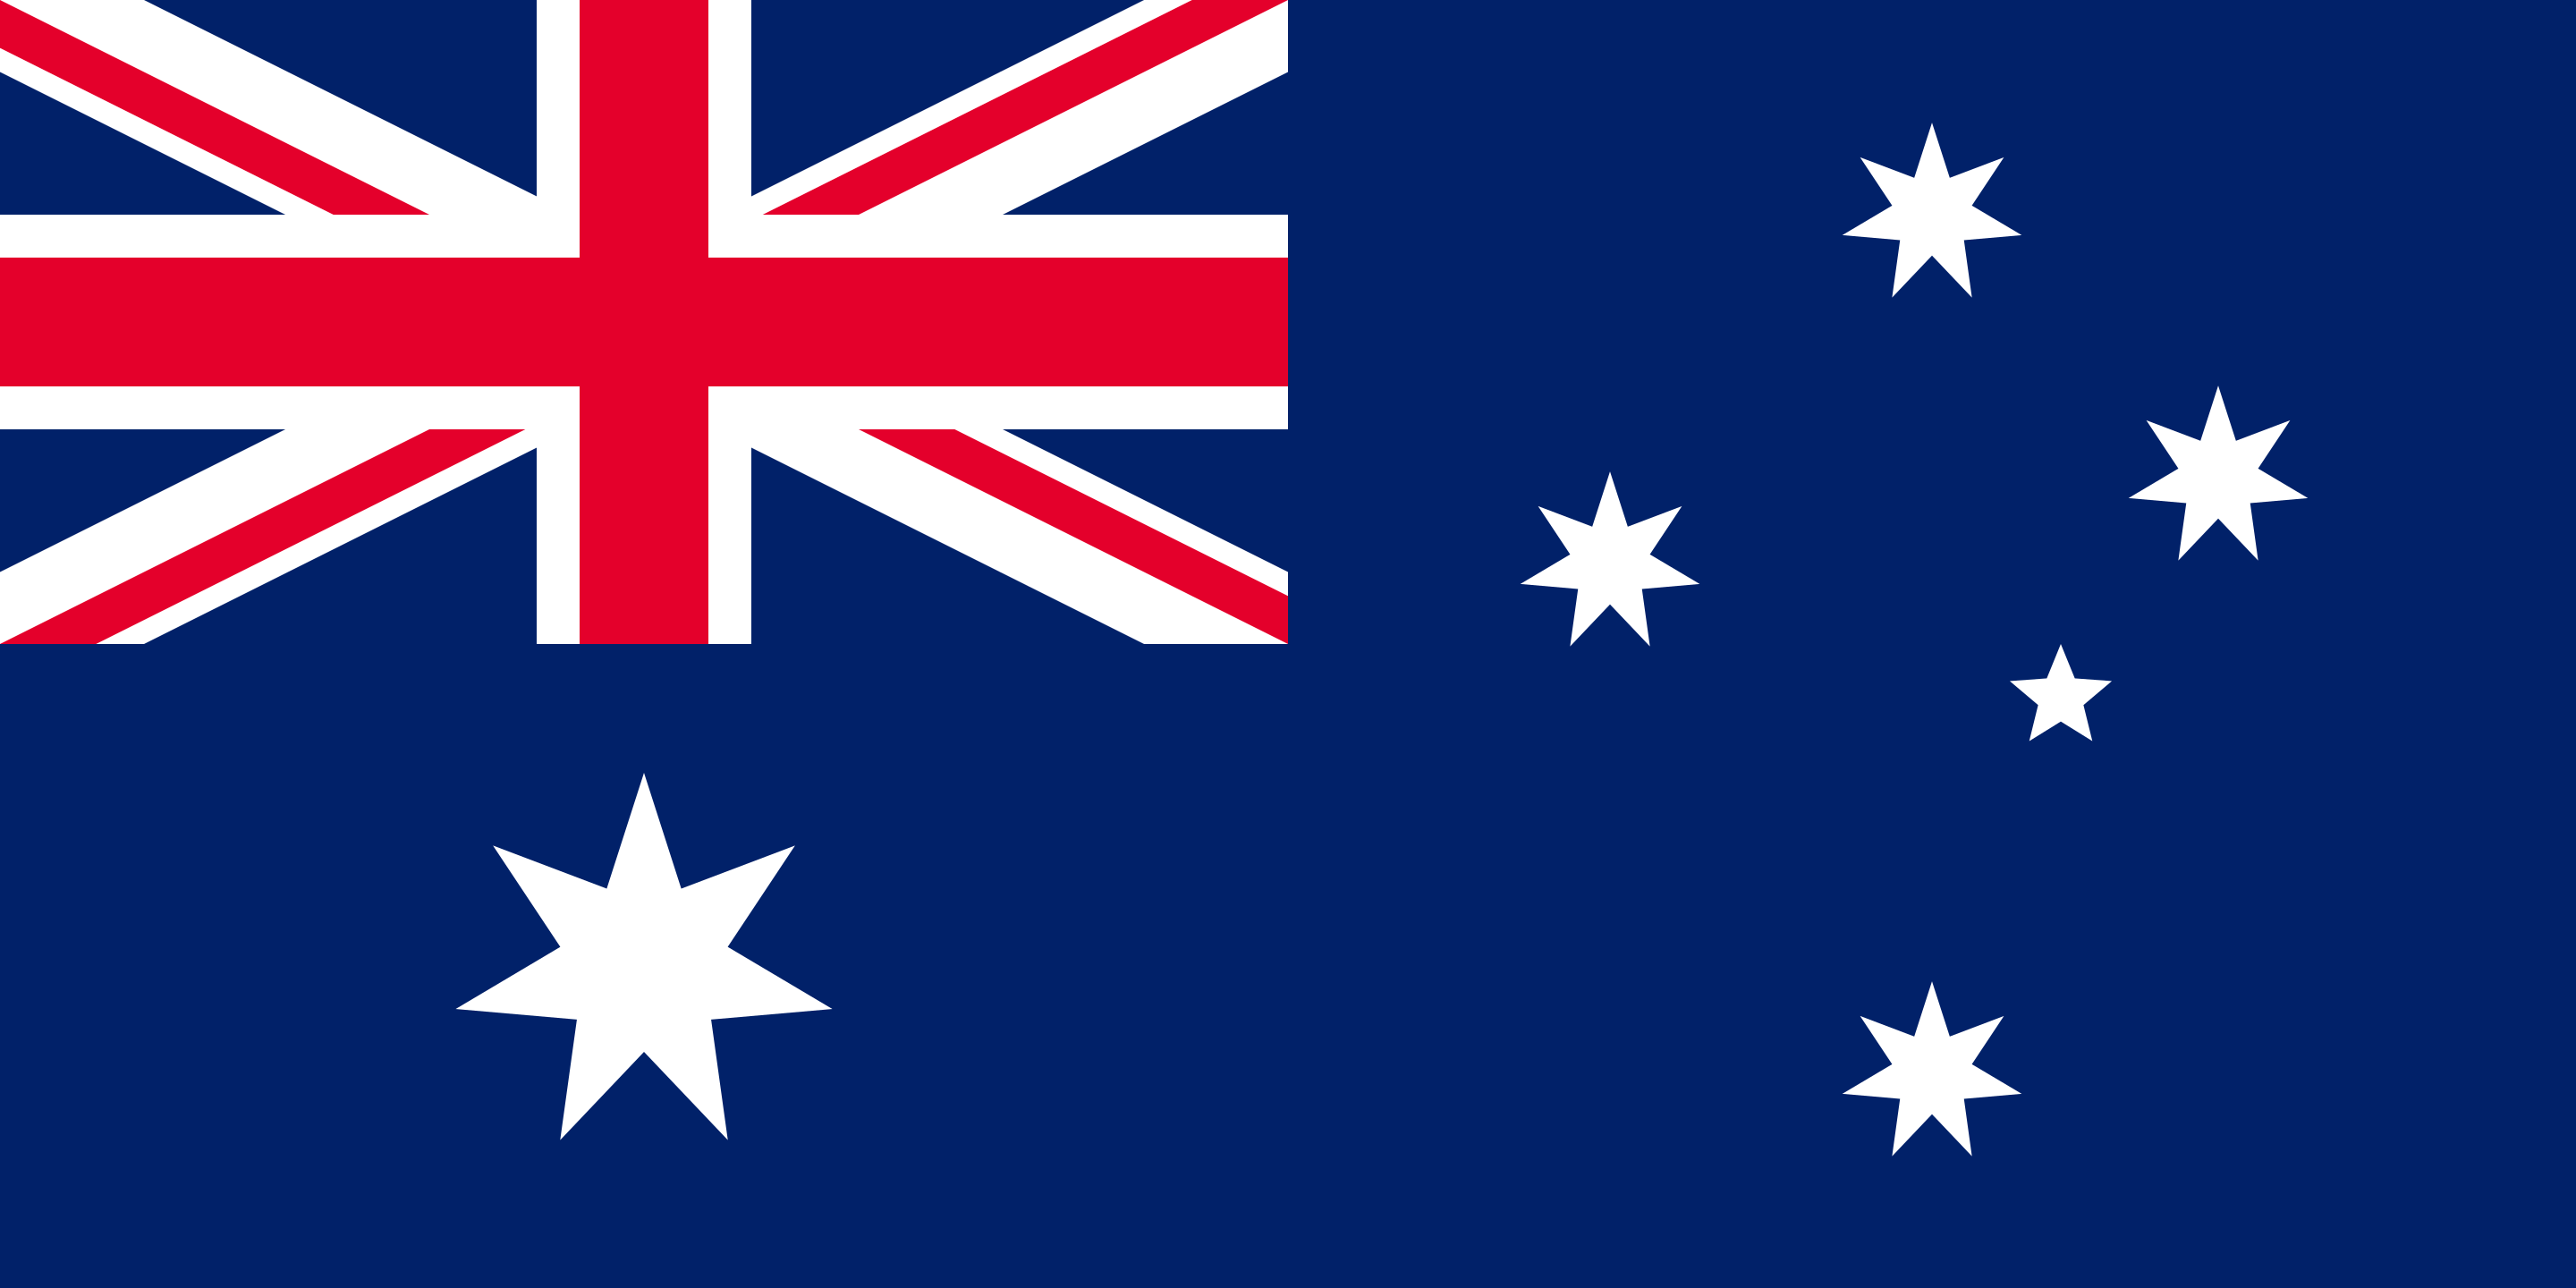

On May 18, 2019, the 2019 Australian federal election was held to elect members of the 46th parliament of Australia. As is the case with many modern elections, many people around the world shared their thoughts and opinions regarding the election on Twitter, the popular social media site.

The purpose of this project is to perform a *sentiment analysis* on a large collection of tweets about the 2019 Australian election. We will analyze a dataset consisting of about 180,000 tweets, each of which has been assigned a sentiment label of "positive", "negative", or neutral. We will construct a variety of machine learning classifiers, which we will use to predict the sentiment label of a given tweet based on the collection of words in the tweet.

In the end, we will compare the performances of our various models, and outline some possible applications of these models.

# Sentiment Analysis Project

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Cleaning the data

In this section, we will illustrate the process of converting each tweet into a string which can be easily handled by our machine learning models. More precisely, for each tweet, we will remove special characters, convert all letters to lower case, and remove all "stem words", which are commonly used words which we do not expect to correlate with the sentiment of the tweet. This may be achieved by running the cell below. For convenience, we provide the resulting dataset in the following section.

In [3]:
full_data = pd.read_csv('/content/drive/MyDrive/PreProData_v2.csv')
data = full_data.copy()[['tweet','sentiment_label']]

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

corpus = []
for i in range(len(data)):
  tweet = str(data['tweet'][i])
  tweet = re.sub('[^a-zA-Z]', ' ', tweet)
  tweet = tweet.lower()
  tweet = tweet.split()
  clean_tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
  clean_tweet = ' '.join(clean_tweet)
  corpus.append(clean_tweet)

data['clean_tweet'] = corpus

data.dropna(inplace=True)

data.head()

,tweet,sentiment_label,clean_tweet
0,After the climate election: shellshocked green...,positive,climat elect shellshock green group remain res...
1,@narendramodi @smritiirani Coverage of indian ...,neutral,narendramodi smritiirani coverag indian elect ...
2,@workmanalice Do you know if Facebook is relea...,negative,workmanalic know facebook releas elect post mo...
3,@vanbadham We all understand we have a compuls...,negative,vanbadham understand compulsori prefer system ...
4,"Shares were mixed in Asia, with India and Aust...",positive,share mix asia india australia lead gain regio...


# Preparing our data

We begin by loading our preprocessed dataset.

In [4]:
data = pd.read_csv('/content/drive/MyDrive/processed_tweet_data.csv')
len(data)

183271

In [5]:
data.head()

,tweet,sentiment_label,clean_tweet
0,After the climate election: shellshocked green...,positive,climat elect shellshock green group remain res...
1,@narendramodi @smritiirani Coverage of indian ...,neutral,narendramodi smritiirani coverag indian elect ...
2,@workmanalice Do you know if Facebook is relea...,negative,workmanalic know facebook releas elect post mo...
3,@vanbadham We all understand we have a compuls...,negative,vanbadham understand compulsori prefer system ...
4,"Shares were mixed in Asia, with India and Aust...",positive,share mix asia india australia lead gain regio...


As we can see, our dataset consists of 183,271 tweets, each of which is labelled as "positive", "neutral", or "negative".

In [6]:
positive = 0
neutral = 0
negative = 0
for i in range(len(data)):
  if data['sentiment_label'][i] == 'positive':
    positive += 1
  elif data['sentiment_label'][i] == 'neutral':
    neutral += 1
  else:
    negative += 1
print('Percent positive: ', (positive/183271)*100)
print('Percent neutral: ', (neutral/183271)*100)
print('Percent negative: ', (negative/183271)*100)

Percent positive:  36.9196435879108
Percent neutral:  35.94403915513092
Percent negative:  27.136317256958275


We find that about 37% of the tweets are labeled 'positive', about 36% are labeled 'neutral', and about 27% are labeled 'negative'.

Since our dataset is so large, we opt to train and test on a much smaller dataset, consisting of the first 10,000 of these tweets.

In [7]:
reduced_data = data.iloc[:10000]
len(reduced_data)

10000

In order to train our models, we need to vectorize our data. Each tweet in our dataset will be transformed into a vector of length 5,000, which encodes the various words present in the tweet. The collection of all such vectors will form the input X for our models.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 5000, min_df = 3, max_df = 0.6)
X = vectorizer.fit_transform(reduced_data['clean_tweet']).toarray()

The target output Y consists of entries which are 1, 0, or -1, corresponding to the sentiment of the tweet being positive, neutral, or negative, respectively.

In [9]:
sentiment_dictionary = {'positive':1, 'neutral': 0, 'negative': -1}

Y = [sentiment_dictionary[reduced_data['sentiment_label'][i]] for i in range(len(reduced_data))]

Y = np.array(Y)

Next, we split our dataset into a training set (X_train, Y_train) and a testing set (X_test, Y_test).

In [10]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                     Y,
                                                     test_size = 0.2,
                                                    random_state = 0,
                                                    shuffle = True)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8000, 4005), (2000, 4005), (8000,), (2000,))

# Naive Bayesian Classifier

We construct our first model, namely a Naive Bayesian Classifier.

In [11]:
from sklearn.naive_bayes import GaussianNB

NB_model = GaussianNB()
NB_model.fit(X_train, Y_train)
NB_model.score(X_test, Y_test)

0.505

We see that the accuracy of our initial model is 50.5%. We can further visualize the performance of our model by plotting the confusion matrix.

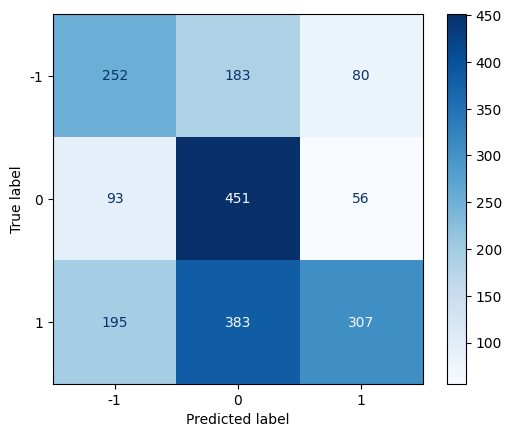

In [12]:
Y_pred = NB_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

We can improve our model by adjusting our hyperparameters. For instance, our Naive Bayesian classifier has a parameter called "var_smoothing", whose default value is 1. We can visualize how the performance of our model varies as we vary var_smoothing using the plot below.

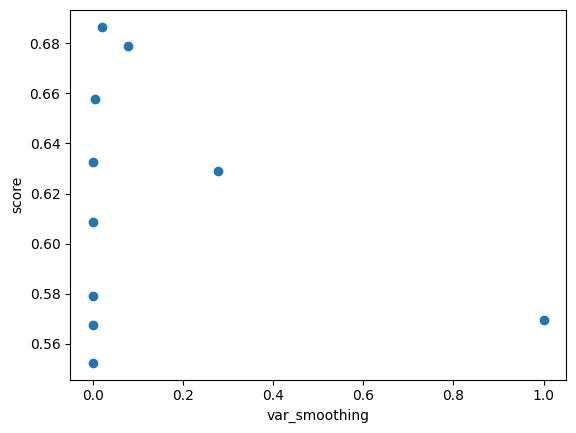

In [13]:
values = np.logspace(-5,0, num=10)
scores = []

for value in values:
  NB_model = GaussianNB(var_smoothing = value)
  NB_model.fit(X_train, Y_train)
  scores.append(NB_model.score(X_test, Y_test))

plt.scatter(values,scores)
plt.xlabel("var_smoothing")
plt.ylabel("score")
plt.show()
plt.close()

In order to find the optimal value of var_smoothing, we perform a gridsearch.

In [14]:
gridsearch_NB = GridSearchCV(estimator=GaussianNB(),
                 param_grid= {'var_smoothing': np.logspace(-5,0, num=30)},
                 verbose=1,
                 cv = 2,
                 scoring='accuracy')
gridsearch_NB.fit(X_train, Y_train)

gridsearch_NB.best_params_

Fitting 2 folds for each of 30 candidates, totalling 60 fits


{'var_smoothing': 0.04175318936560404}

We've found that the optimal value of var_smoothing for our dataset is approximately 0.04. Let's see how our model performs with this parameter value.

In [15]:
NB_model = GaussianNB(var_smoothing = gridsearch_NB.best_params_['var_smoothing'])
NB_model.fit(X_train, Y_train)
NB_model.score(X_test, Y_test)

0.689

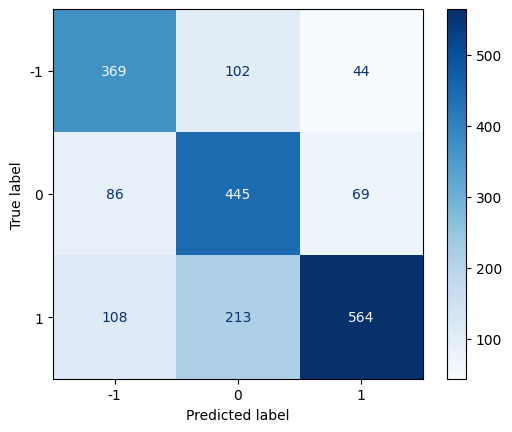

In [16]:
Y_pred = NB_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

By adjusting the parameter var_smoothing, we've improved the performance of our model from an accuracy of 50.5%, to an accuracy of 68.9%.

# Decision Tree Classifier

We constuct our second model, namely a Decision Tree Classifier.

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
DTC_model = DecisionTreeClassifier()
DTC_model.fit(X_train, Y_train)
DTC_model.score(X_test,Y_test)

0.731

We see that the accuracy of this model is 73.1%. We can further visualize the performance of our decision tree classifier using the confusion matrix below.

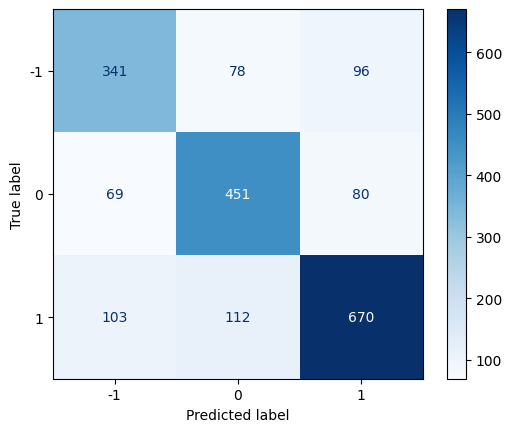

In [19]:
Y_pred = DTC_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

# Random Forest Classifier

Next, we implement a Random Forest Classifier.

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
RF_model = RandomForestClassifier(n_estimators = 10)
RF_model.fit(X_train, Y_train)
RF_model.score(X_test, Y_test)

0.775

We see that the accuracy of our model is 77.5%. We plot the associated confusion matrix below.

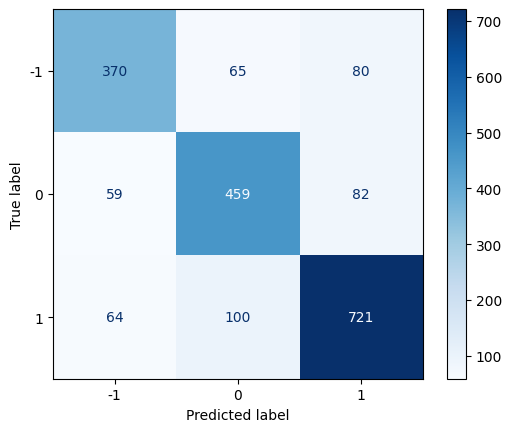

In [22]:
Y_pred = RF_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

We can improve our model by adjusting our hyperparameters. For instance, our Random Forest classifier has a parameter called "n_estimators", representing the number of trees in the random forest, whose default value is 100. We can visualize how the performance of our model varies as we vary n_estimators using the plot below.

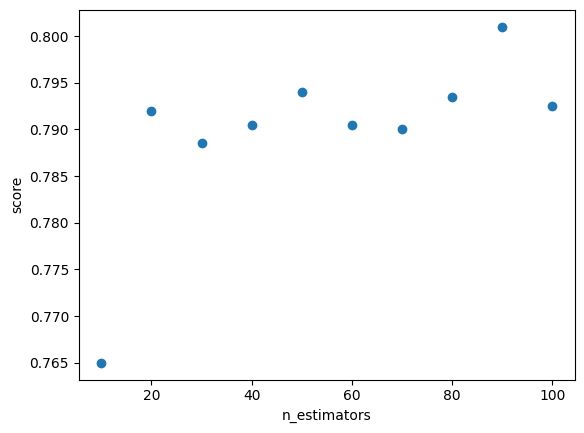

In [23]:
values = np.linspace(10,100, num=10)
scores = []

for value in values:
  RF_model = RandomForestClassifier(n_estimators = int(value))
  RF_model.fit(X_train, Y_train)
  scores.append(RF_model.score(X_test, Y_test))

plt.scatter(values,scores)
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.show()
plt.close()

We see that the performance of our model plateaus at about n_estimators = 40, so we choose this for our parameter value. Let's see how our new model performs.

In [24]:
RF_model = RandomForestClassifier(n_estimators = 40)
RF_model.fit(X_train, Y_train)
RF_model.score(X_test, Y_test)

0.7935

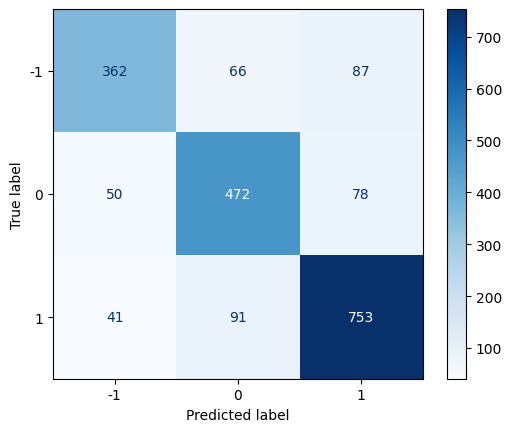

In [25]:
Y_pred = RF_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

By adjusting the parameter n_estimators, we improved the performance of our model from about 77.5% to 79.35%. This is a marginal improvement, but an improvement nonetheless.

# Logistic Regression

Next, we implement a Logistic Regression classifier.

In [26]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(X_train, Y_train)
LR_model.score(X_test, Y_test)

0.7885

We see that the Logistic Regression model has an accuracy of 78.85%. We plot the associated confusion matrix below.

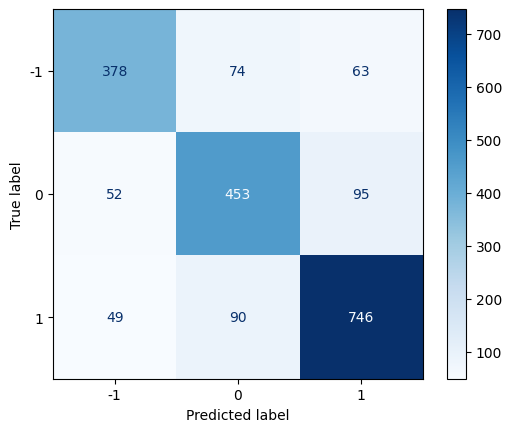

In [27]:
Y_pred = LR_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

We can improve our model by adjusting our hyperparameters. For instance, our Logistic Regression classifier has a parameter called "C", representing the inverse of regulization strength, whose default value is 1. We can visualize how the performance of our model varies as we vary C using the plot below.

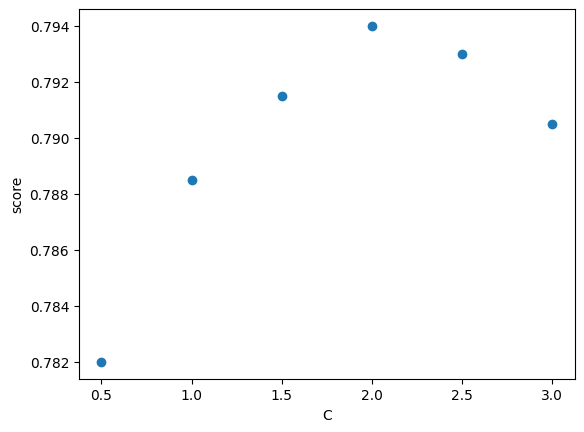

In [28]:
values = np.linspace(0.5,3, num=6)
scores = []

for value in values:
  LR_model = LogisticRegression(C = value)
  LR_model.fit(X_train, Y_train)
  scores.append(LR_model.score(X_test, Y_test))

plt.scatter(values,scores)
plt.xlabel("C")
plt.ylabel("score")
plt.show()
plt.close()

In [29]:
gridsearch_LR = GridSearchCV(estimator=LogisticRegression(),
                 param_grid= {'C': np.linspace(1.5,2.5, num=8)},
                 verbose=1,
                 cv = 2,
                 scoring='accuracy')
gridsearch_LR.fit(X_train, Y_train)

gridsearch_LR.best_params_

Fitting 2 folds for each of 8 candidates, totalling 16 fits


{'C': 2.5}

We've found that the optimal value of C for our Logistic Regression model is C = 2.5. Let's see how our model performs with this parameter value.

In [30]:
LR_model = LogisticRegression(C = gridsearch_LR.best_params_['C'])
LR_model.fit(X_train, Y_train)
LR_model.score(X_test, Y_test)

0.793

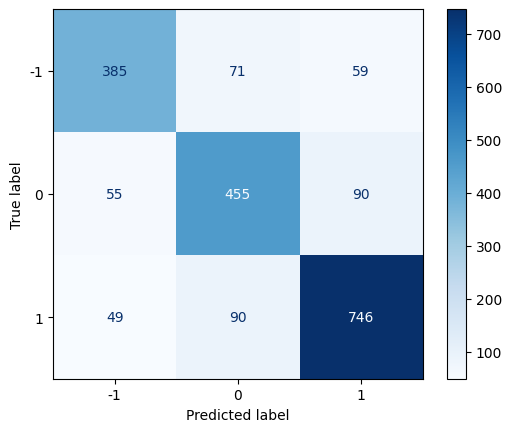

In [31]:
Y_pred = LR_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

By adjusting the parameter C, we improved the performance of our model from 78.85% to about 79.3%. This is a marginal improvement, but an improvement nonetheless.

# SVC

Our first model is a Support Vector Classification (SVC) model. We compare to instances of this model, one with a linear kernel, and one with a rbf (radial basis function) kernel.

In [32]:
from sklearn.svm import SVC

SVC_model = SVC(kernel = 'linear')
SVC_model.fit(X_train, Y_train)
SVC_model.score(X_test,Y_test)

0.788

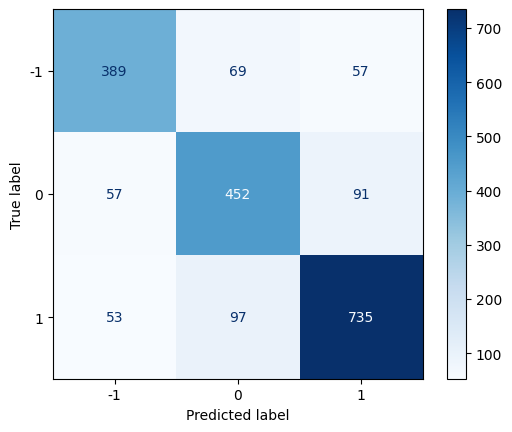

In [33]:
Y_pred = SVC_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

We see that the SVC with linear kernel has an accuracy of 78.8%. Let's try a SVC with radial basis function (rbf) kernel and compare the results.

In [34]:
SVC_model = SVC(kernel = 'rbf')
SVC_model.fit(X_train, Y_train)
SVC_model.score(X_test,Y_test)

0.797

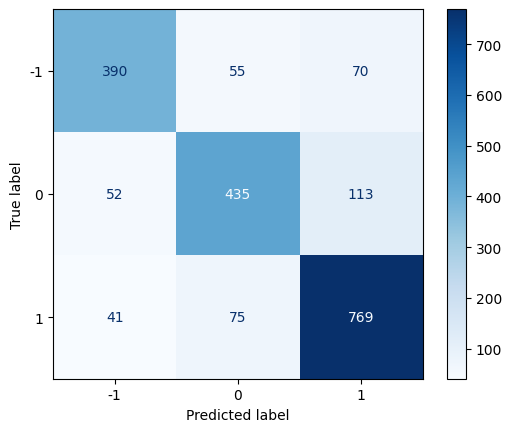

In [35]:
Y_pred = SVC_model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred,cmap=plt.cm.Blues)

We see that a linear kernel results in an accuracy of 78.8%, while a radial basis function kernel results in an accuracy of 79.7%.

# Conclusion

Having trained and tested our various models, we find that each of the five models performs reasonably well. In particular, each model correctly predicts sentiment with an accuracy between 67% and 80%. Of the five models, we find that the Support Vector Classification (SVC) model with radial basis function (rbf) kernel was most effective, achieving an accuracy of 79.7% on the testing data.

One possible use of our model is to predict party affilliation of a twitter user given the sentiment of their tweets before and after an election. This could inform political parties of the nature of advertisements to present to such users.